# Test/Debuger for the predict.py file

In [2]:
import os
import torch
import segmentation_models_pytorch as smp
import yaml
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import json
from PIL import Image, ImageOps
import numpy as np

In [3]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define image transformation using resize 
transform_resize = Compose([
    Resize((224, 224)), ToTensor(),  # Convert the image to a tensor
])

# Define image transformation using padding
transform_pad = Compose([
    ToTensor(),  # Convert the image to a tensor
])

In [7]:
# Load the config file
config_path = '../runs/unet_smp/split_debug/config/config.yaml' # update with the correct yaml

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Extract values from the config
checkpoint_path = os.path.join(config['path_checkpoints'], 'checkpoint_epoch100.pth')
data_root = config['path_data']
annotations_root = config['annotations_root']
image_size = config['image_size']
in_channels = config['in_channels']
out_channels = config['out_channels']
encoder_name = config['encoder_name']
encoder_weights = config['encoder_weights']
image_folder = os.path.join(config['path_data'], 'images')

In [5]:
# Load the pre-trained model with checkpoint
model = smp.Unet(
    encoder_name=encoder_name,                   
    encoder_weights=encoder_weights,             
    in_channels=in_channels,                     # Number of input channels (3 for RGB)
    out_channels=out_channels,                   # Number of output channels (1 for binary)
    activation='sigmoid'                         # Sigmoid activation
)
model = model.to(device)

In [ ]:
# Create a custom dataset for validation
annotations_path = os.path.join(annotations_root, 'val.json')

with open(annotations_path) as f:
    annotations = json.load(f)

# Extract relevant parts of the annotations
image_annotations = {annotation['image_id']: annotation for annotation in annotations['annotations']}
image_info = {image['id']: image for image in annotations['images']}

# Load the model weights from checkpoint
model.load_state_dict(torch.load(checkpoint_path))
model.eval()  # Set the model to evaluation mode

In [11]:
# Annotations by image id
def get_annotation_by_image_id(image_id):
    return image_annotations.get(image_id, None)

# Padding
def pad_to_divisible(image: Image.Image):
    width, height = image.size # original image size

    padding_width = (32 - width % 32) % 32 # padding needed on w
    padding_height = (32 - height % 32) % 32 # padding needed on h
    
    pad_left = padding_width // 2 # pad half w on the left
    pad_right = padding_width - pad_left # pad half w on right
    pad_top = padding_height // 2 # pad half h on top
    pad_bottom = padding_height - pad_top # pad half h on bottom 
    
    padded_image = Image.new("RGB", (width + padding_width, height + padding_height), (0, 0, 0))
    padded_image.paste(image, (pad_left, pad_top))    

    return padded_image

# Function to predict based on an image
def predict(image_path, transform, model, device, padding):
    image = Image.open(image_path).convert("RGB") # open image

    if padding == 1: # apply padding if necessary
        image = pad_to_divisible(image)
        transform = transform_pad
    if padding == 0:
        transform = transform_resize

    image_tensor = transform(image).unsqueeze(0).to(device)/255  # apply transformation
    
    # Perform prediction
    with torch.no_grad():
        output = model(image_tensor)  # Forward pass
    
    # Sigmoid for binary segmentation (if required)
    output_mask = torch.sigmoid(output).squeeze().cpu().numpy()  # Move output back to CPU for visualization
    
    return output, output_mask


In [20]:
# Example usage
image_path = '/mnt/class_data/group2/alexandradigiacomo/dataset/images/07252023PANB0201.JPG' # from debug val
image_path = '/mnt/class_data/group2/alexandradigiacomo/dataset/images/07202023PANB0201.JPG' # from debug train
#image_path = '/mnt/class_data/group2/alexandradigiacomo/dataset/images/07252023PANB0201.JPG' # from val  
#image_path ='/mnt/class_data/group2/alexandradigiacomo/dataset/images/07202023PANB0201.JPG' # from train

output, output_mask = predict(image_path, transform_resize, model, device, padding = 0)


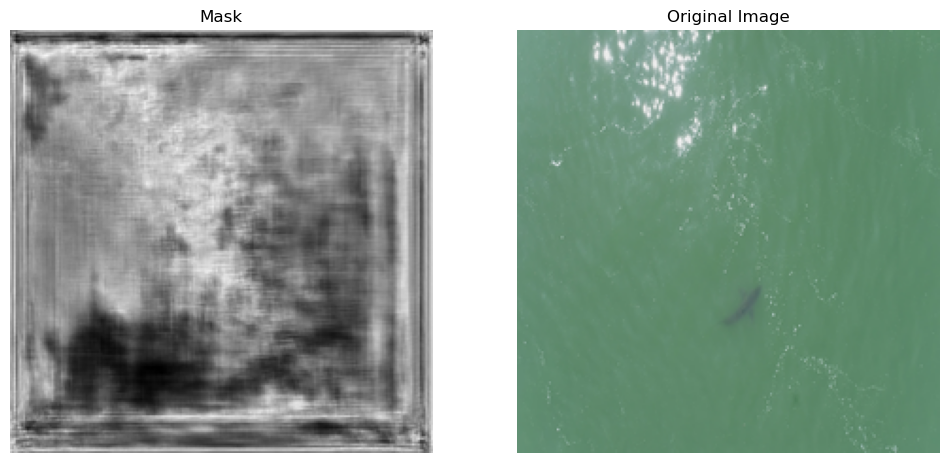

In [ ]:
# Example visualization
output_display = output.cpu().squeeze().numpy()
output_mask_display = output_mask

# Resize the image to match the output mask size 
original_image = Image.open(image_path).convert("RGB")
output_mask_size = output_display.shape[::-1]  # mask size
original_image_resized = original_image.resize(output_mask_size, Image.Resampling.LANCZOS) # resize img to mask size
original_image_resized = np.array(original_image_resized)

# Create the subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the mask
axes[0].imshow(output_display, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Mask')

# Plot the resized image
axes[1].imshow(original_image_resized)
axes[1].axis('off')
axes[1].set_title('Original Image')

plt.show()